<div style="display: flex;">
<img alt="fit hcmus logo" width="300" src="https://www.ctda.hcmus.edu.vn/wp-content/uploads/2022/03/FIT-logo_dat_kem_voi_logo_truong.png" onerror='this.src="https://courses.fit.hcmus.edu.vn/pluginfile.php/1/theme_academi/logo/1698750738/fit-logo-chuan-V2-MOODLE.jpg"'></img>
<div style="display: flex; flex-direction:column; justify-content: center" >
<h4 style="text-align:right; margin: 0">VNUHCM-UNIVERSITY OF SCIENCE &emsp;</h4>
<h4 style="text-align:right; margin: 0">FACULTY OF INFORMATION TECHNOLOGY &emsp;</h4>
</div>
</div>

---

# <p style="text-align:center"><b>Sinh trắc học 20-21 / HK1 / 2023-2024</b></p>
# <p style="text-align:center"><b>LAB 02 - NHẬN DẠNG BẰNG DEEP LEARNING</b></p>
<p style="text-align:center"> GVLT: Lê Hoàng Thái</p>
<p style="text-align:center"> GVTH: Lê Thanh Phong</p>

**Họ và tên:** Lê Hoài Phong</br>
**MSSV:** 20120545</br>
**SĐT:** 0387671963 </br>
**Email:** 20120545@student.hcmus.edu.vn </br>

<p style="text-align:center"> <i>Thành phố Hồ Chí Minh, ngày 10 tháng 12 năm 2023</i></p>

---

# **I - THÔNG TIN CHUNG**
Em chọn Bài tập 1: Nhận diện khuôn mặt.

Sử dụng Dataset Pins Face Recognition gồm 105 class, tổng cộng 17534 ảnh.

Huấn luyện 4 mô hình:
- Yolov8 + FaceNet + SVC
- MTCNN + FaceNet
- Yolov8 + VggFace (finetuning 6 layer cuối)
- MTCNN + VggFace (finetuning 6 layer cuối)

Thực hiện đánh giá và so sánh 4 mô hình trên.

# **II - SETUP**

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.6 MB/s eta 0:00:00


In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 9.9 MB/s eta 0:00:00


In [2]:
!pip install ultralytics keras-facenet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.1 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=cef8c09d2cfcd5aa1889bf094baf5554413adde91858b83fe4adc23c20992e68
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


In [3]:
# Common
import os
import cv2 as cv
import numpy as np
import pandas as pd
from IPython.display import clear_output as cls
from PIL import Image
import pickle
import tensorflow as tf
import torch
from PIL import Image
import time

# Data
from tqdm import tqdm
from glob import glob

# Data Visuaalization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [4]:
# Setting a random
np.random.seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Sinh trắc học - Lab02 - Bài nộp/20120545/Source"

/content/drive/MyDrive/Sinh trắc học - Lab02 - Bài nộp/20120545/Source


In [6]:
# %cd "/content/drive/MyDrive/Source"

/content/drive/.shortcut-targets-by-id/1FikZj531L8cTNrvyHx3l7opBGhyDtYBo/Source


In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
# Check for GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# unzip dataset in drive
# !unzip "archive.zip"

# **III - LOAD DATASET**
+ Thực hiện bước này khi muốn detect và align face lại.
+ Bỏ qua bước này nếu sử dụng file npy (aligned face)

## III.1 - Tải dataset lên và kiểm tra

In [26]:
# Specify the root directory path
root_path = '105_classes_pins_dataset/'

# Collect all the person names
dir_names = os.listdir(root_path)
person_names = [name.split("_")[-1].title() for name in dir_names]
n_individuals = len(person_names)

print(f"Total number of individuals: {n_individuals}\n")
print(f"Name of the individuals : \n\t{person_names}")

Total number of individuals: 105

Name of the individuals : 
	['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Amanda Crew', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Avril Lavigne', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Gwyneth Paltrow', 'Henry Cavil', 'Hugh Jackman', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jennifer Lawrence', 'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johnny Depp', 'Josh Radnor', 'Katharine Mcphee', 'Katherine Langford', 'Keanu Reeves', 'Krysten Ritter', 'Leonardo Dicaprio', 'Lili Reinhart', 'Lindsey Morgan', 'Lionel Messi', 'Logan Lerman', 'Madelaine Petsch', 'Maisie Williams', 'Maria Pedraza', 'Marie Avgeropoulos', 'Mar

In [27]:
# Number of images available per person
n_images_per_person = [len(os.listdir(root_path + name)) for name in dir_names]
n_images = sum(n_images_per_person)

# Show
print(f"Total Number of Images : {n_images}.")

Total Number of Images : 17534.


In [ ]:
# Plot the Distribution of number of images per person.
fig = px.bar(x=person_names, y=n_images_per_person, color=person_names)
fig.update_layout({'title':{'text':"Distribution of number of images per person"}})
fig.show()

## III.2 - Split dataset

In [28]:
from sklearn.model_selection import train_test_split

train_paths =[]
train_labels = []
test_paths =[]
test_labels = []

for sub_folder in dir_names:
  file_paths = os.listdir(os.path.join(root_path,sub_folder))
  train, test = train_test_split(file_paths, test_size=0.2, random_state=42)

  for img in train:
      train_paths.append(os.path.join(root_path, sub_folder, img))
      train_labels.append(sub_folder.split("_")[-1])
  for img in test:
      test_paths.append(os.path.join(root_path, sub_folder, img))
      test_labels.append(sub_folder.split("_")[-1])

In [ ]:
n_train = len(train_labels)
n_test = len(test_labels)

print(f"Size of train set: {n_train}")
print(f"Size of test set: {n_test}")
print(f"Split ratio: {n_test/(n_test+n_train)*100}%")

Size of train set: 13979
Size of test set: 3555
Split ratio: 20.274894490703776%


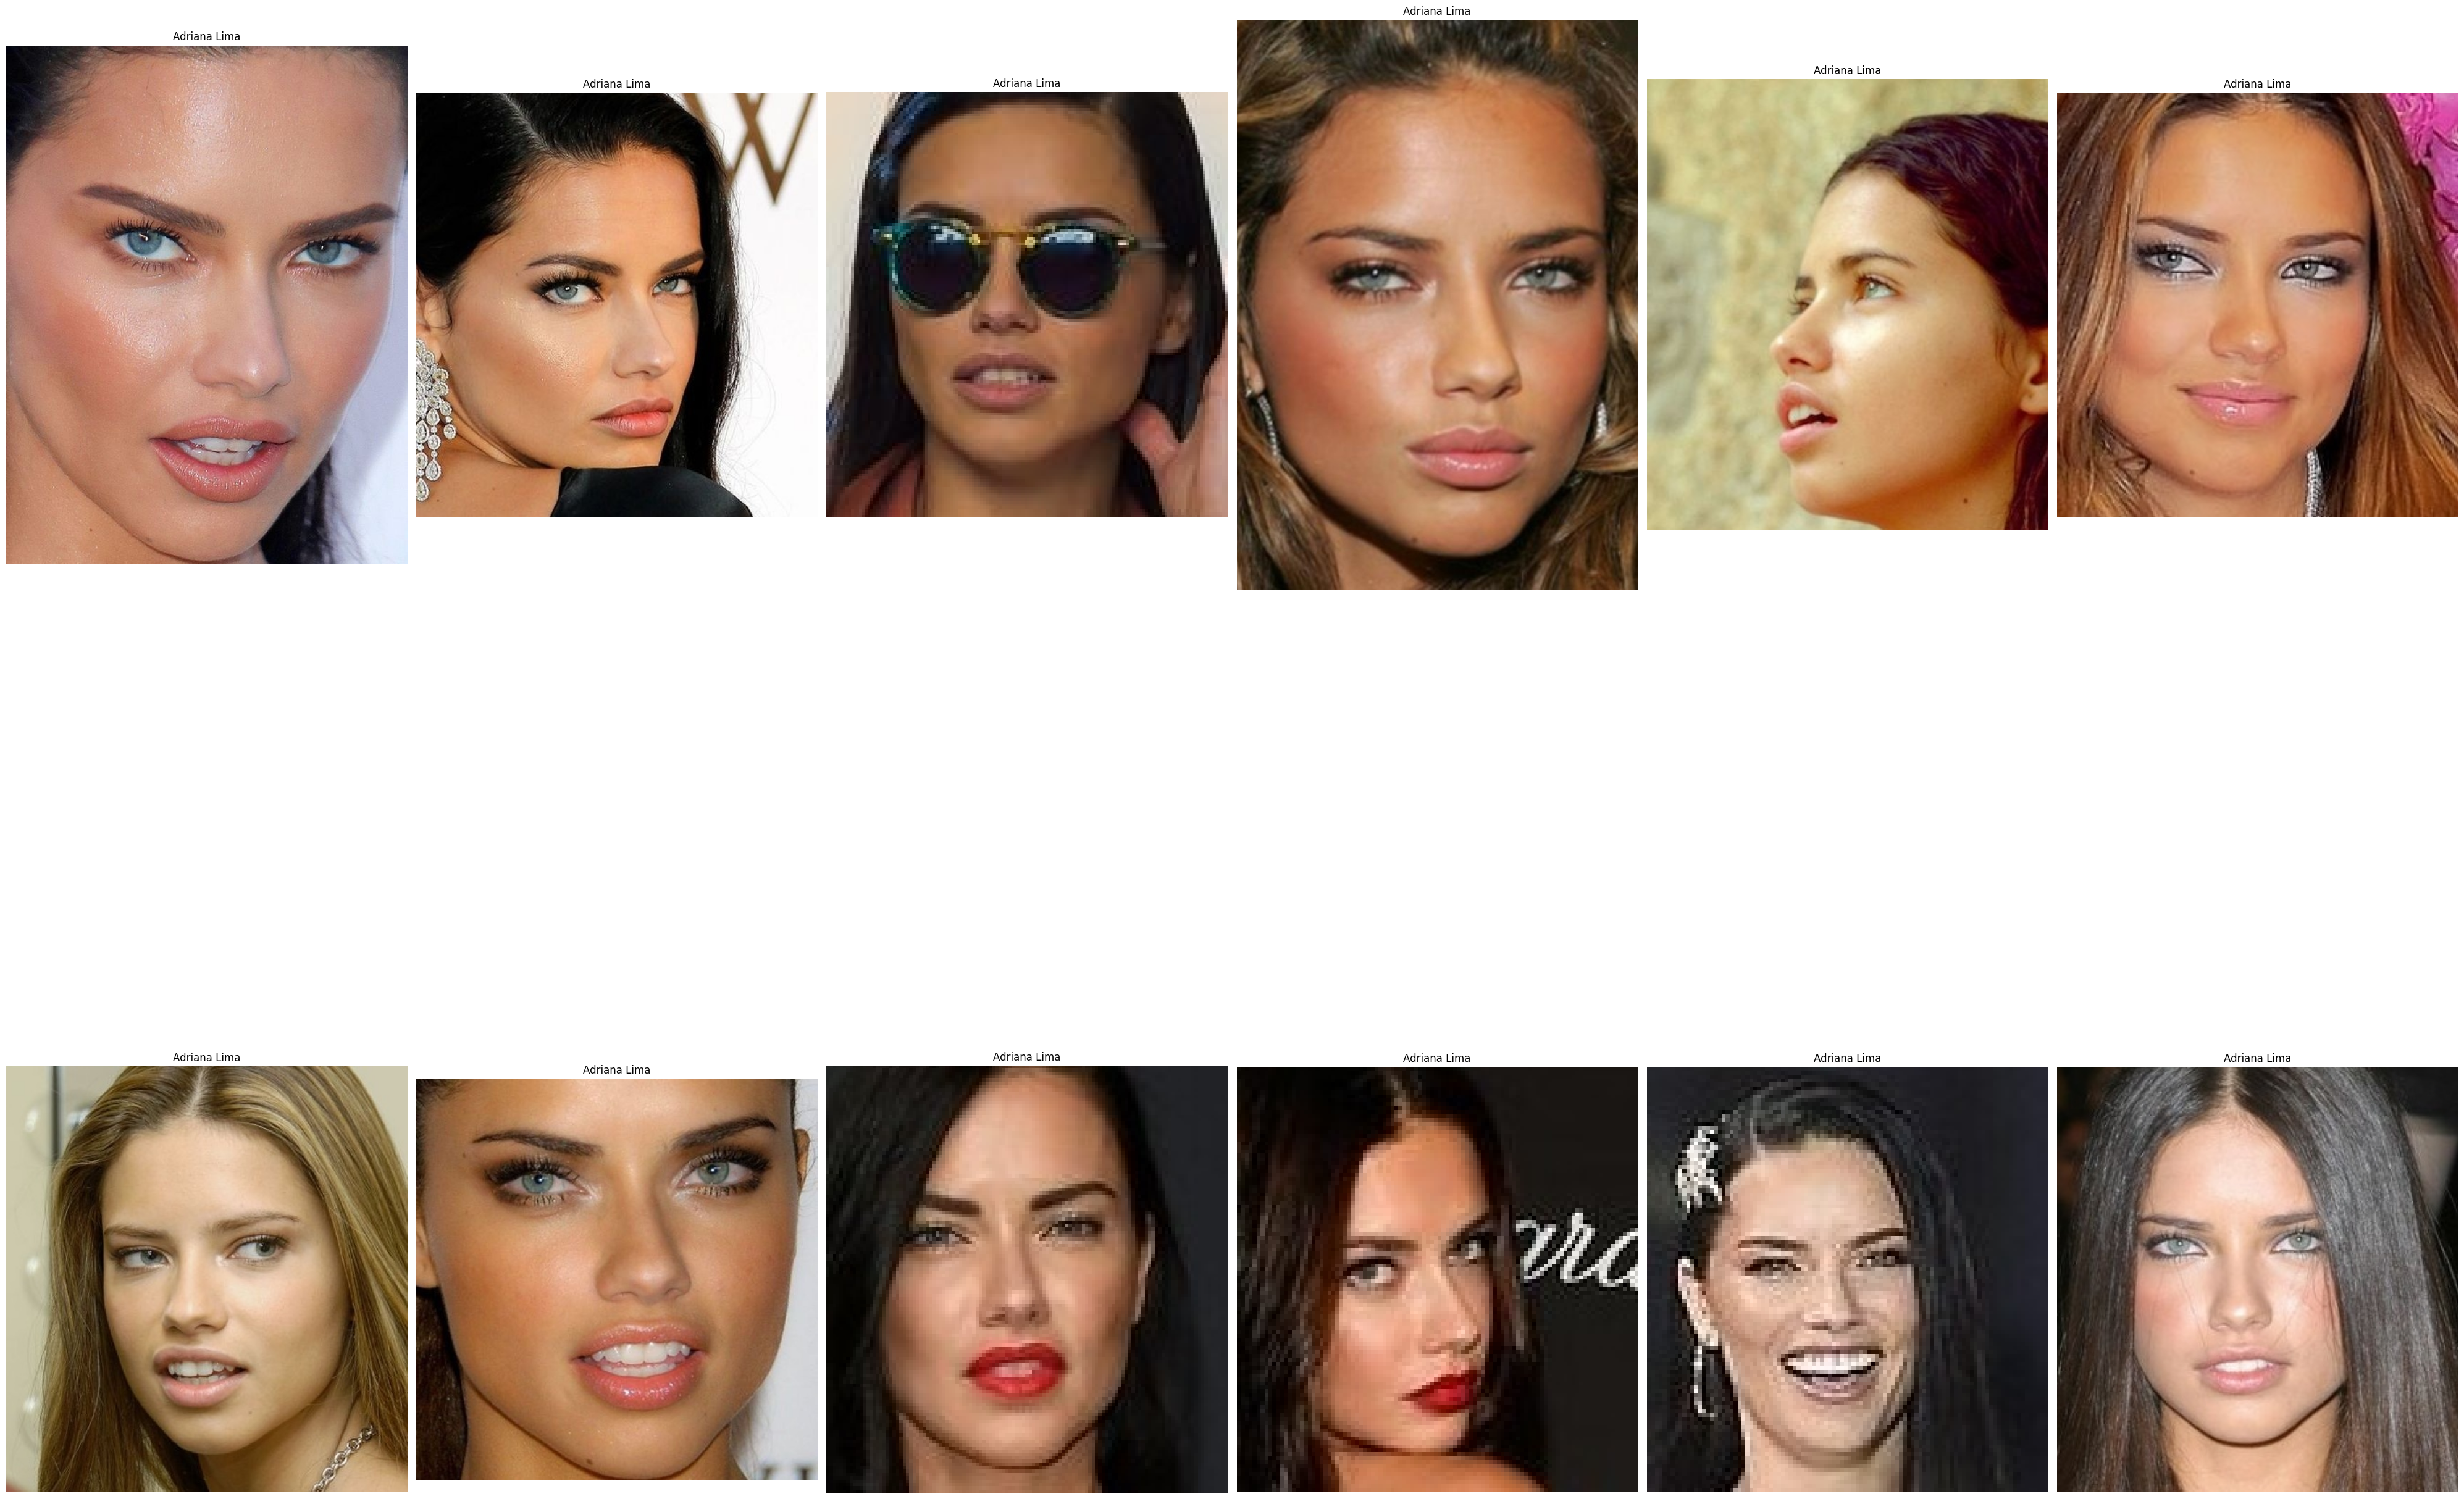

In [32]:
images = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in train_paths[:12]]
labels = train_labels[:12]

# Plotting Configuration
plt.figure(figsize=(40, 40))
n_rows, n_cols = (2, 6)
n_images = n_rows * n_cols

# loop over the images and labels
for index in range(n_images):
    # Create a Subplot
    plt.subplot(n_rows, n_cols, index+1)

    # Plot Image
    plt.imshow(images[index])
    plt.axis('off')
    plt.title(labels[index])

# Show final Plot
plt.tight_layout()
plt.show()

# **IV-FACE DETECTION**
+ Thực hiện bước 1+2, bỏ qua bước 3 khi muốn detect và align face lại.
+ Bỏ qua bước 1+2, thực hiện bước 3 nếu sử dụng file npy (aligned face)

In [ ]:
# Image dimensions for FaceNet
w1, h1, c1 = (160, 160, 3)
# Image dimensions for VggFace
w2, h2, c2 = (224, 224, 3)

In [ ]:
# Align face
def crop_and_resize_image(original_img, coordinate, size):
    x1, y1, x2, y2 = map(int, coordinate)
    cropped_img = original_img[y1:y2, x1:x2]
    # print(cropped_img.shape)
    cropped_img = cv.resize(cropped_img, size)
    return cropped_img

## IV.1 - Yolov8

### Load model YOLOv8

In [ ]:
from ultralytics import YOLO

In [ ]:
# Load yolo
yolo = YOLO('yolov8n-face.pt')

WARNING ⚠️ yolov8n-face.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['omegaconf'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=39239acce3850ff84eef8c6297bba1774685ed1a48e1cf50e20c84a9bdd1569d
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqyjuq8f/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e

### Detect face for FaceNet

In [ ]:
#extract all faces to corresponding label
def detect_faces_yolo(image_paths, image_labels, size, conf_threshold=0.6):
  aligned_faces = []
  face_labels = []

  for path, label in zip(image_paths, image_labels):
    img = cv.imread(path)
    if img is None:
      continue
    face = yolo(path, conf = conf_threshold)
    coordinate = face[0].cpu().boxes.xyxy.tolist() if face else []
    # print("DEBUG", coordinate)

    if len(coordinate) == 1:
      cropped_image = crop_and_resize_image(img, coordinate[0], size)
      aligned_faces.append(cropped_image)
      face_labels.append(label)
  return np.asarray(aligned_faces), np.asarray(face_labels)

In [ ]:
train_images_Yolo_160, train_labels_Yolo_160 = detect_faces_yolo(train_paths, train_labels, (w1, h1))
test_images_Yolo_160, test_labels_Yolo_160 = detect_faces_yolo(test_paths, test_labels, (w1, h1))

In [ ]:
print(f"# train images: {len(train_images_Yolo_160)}")
print(f"# test images: {len(test_images_Yolo_160)}")

# train images: 12187
# test images: 3117


In [ ]:
# Save aligned face for further use
np.save('train_images_Yolo_160.npy', train_images_Yolo_160)
np.save('train_labels_Yolo_160.npy', train_labels_Yolo_160)
np.save('test_images_Yolo_160.npy', test_images_Yolo_160)
np.save('test_labels_Yolo_160.npy', test_labels_Yolo_160)

### Detect face for VggFace

In [ ]:
train_images_Yolo_224, train_labels_Yolo_224 = detect_faces_yolo(train_paths, train_labels, (w2, h2))
test_images_Yolo_224, test_labels_Yolo_224 = detect_faces_yolo(test_paths, test_labels, (w2, h2))

In [ ]:
print(f"# train images: {len(train_images_Yolo_224)}")
print(f"# test images: {len(test_images_Yolo_224)}")

# train images: 12187
# test images: 3117


In [ ]:
# Save aligned face for further use
np.save('train_images_Yolo_224.npy', train_images_Yolo_224)
np.save('train_labels_Yolo_224.npy', train_labels_Yolo_224)
np.save('test_images_Yolo_224.npy', test_images_Yolo_224)
np.save('test_labels_Yolo_224.npy', test_labels_Yolo_224)

## IV.2-MTCNN

### Detect face for FaceNet

In [ ]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(device=device, image_size = 160, post_process=False)

Kiểm tra mô hình

(160, 160, 3)


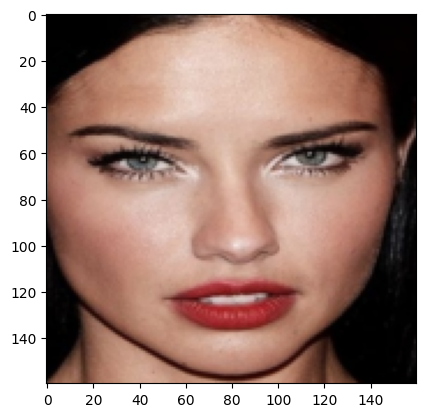

In [ ]:
# img = cv.cvtColor(cv.imread(train_paths[25]), cv.COLOR_BGR2RGB) # tải ảnh lên
img = Image.open(train_paths[25])
face = mtcnn(img)
print(face.permute(1, 2, 0).int().numpy().shape)
plt.imshow(face.permute(1, 2, 0).int().numpy())

In [ ]:
#extract all faces to corresponding label
def detect_faces_mtcnn(image_paths, image_labels):
  aligned_faces = []
  face_labels = []
  count = 0 # for debug

  for path, label in zip(image_paths, image_labels):
    count = count + 1
    if count % 1000 == 0: print("LOG", count//1000) # DEBUG

    # img = cv.imread(path)
    img = Image.open(path)
    if img is None:
        continue
    # img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # face = mtcnn(img_rgb)
    face = mtcnn(img)
    if face is not None:
        aligned_faces.append(face.permute(1, 2, 0).int().numpy().astype(np.uint8))
        face_labels.append(label)

  return np.asarray(aligned_faces), np.asarray(face_labels)

In [ ]:
start_time = time.time()

train_images_mtcnn_160, train_labels_mtcnn_160 = detect_faces_mtcnn(train_paths, train_labels)
test_images_mtcnn_160, test_labels_mtcnn_160 = detect_faces_mtcnn(test_paths, test_labels)

end_time = time.time()
execution_time = end_time - start_time
print(f"Runtime: {execution_time} s")

LOG 1
LOG 2
LOG 3
LOG 4
LOG 5
LOG 6
LOG 7
LOG 8
Runtime: 3344.9584023952484 s


In [ ]:
print(f"# train images: {len(train_images_mtcnn_160)}")
print(f"# test images: {len(test_images_mtcnn_160)}")

In [ ]:
# Save aligned face for further use
np.save('train_images_mtcnn_160.npy', train_images_mtcnn_160)
np.save('train_labels_mtcnn_160.npy', train_labels_mtcnn_160)
np.save('test_images_mtcnn_160.npy', test_images_mtcnn_160)
np.save('test_labels_mtcnn_160.npy', test_labels_mtcnn_160)

### Detect face for VggFace

In [ ]:
start_time = time.time()

train_images_mtcnn_224, train_labels_mtcnn_224 = detect_faces_mtcnn(train_paths, train_labels)
test_images_mtcnn_224, test_labels_mtcnn_224 = detect_faces_mtcnn(test_paths, test_labels)

end_time = time.time()
execution_time = end_time - start_time
print(f"Runtime: {execution_time}s")

In [ ]:
# Save aligned face for further use
np.save('train_images_mtcnn_224.npy', train_images_mtcnn_224)
np.save('train_labels_mtcnn_224.npy', train_labels_mtcnn_224)
np.save('test_images_mtcnn_224.npy', test_images_mtcnn_224)
np.save('test_labels_mtcnn_224.npy', test_labels_mtcnn_224)

## IV.3-Load aligned face

### Yolov8 for FaceNet

In [ ]:
train_images_Yolo_160 = np.load('train_images_Yolo_160.npy')
train_labels_Yolo_160 = np.load('train_labels_Yolo_160.npy')
test_images_Yolo_160 = np.load('test_images_Yolo_160.npy')
test_labels_Yolo_160 = np.load('test_labels_Yolo_160.npy')

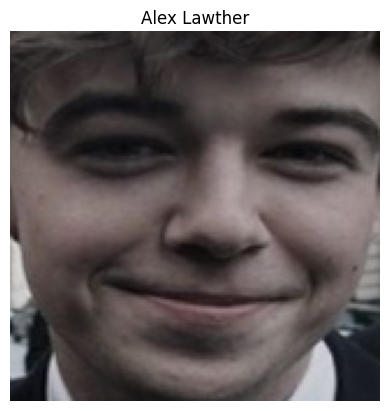

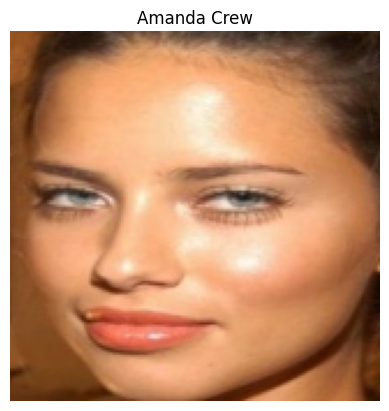

In [ ]:
# Hiển thị ảnh
plt.imshow(cv.cvtColor(train_images_Yolo_160[234], cv.COLOR_BGR2RGB))
plt.title(train_labels_Yolo_160[234])
plt.axis('off')
plt.show()

plt.imshow(cv.cvtColor(train_images_Yolo_160[130], cv.COLOR_BGR2RGB))
plt.title(test_labels_Yolo_160[130])
plt.axis('off')
plt.show()

In [ ]:
print(train_images_Yolo_160.shape)

(12187, 160, 160, 3)


### Yolov8 for VggFace

In [ ]:
train_images_Yolo_224 = np.load('train_images_Yolo_224.npy')
train_labels_Yolo_224 = np.load('train_labels_Yolo_224.npy')
test_images_Yolo_224 = np.load('test_images_Yolo_224.npy')
test_labels_Yolo_224 = np.load('test_labels_Yolo_224.npy')

### MTCNN for FaceNet

In [8]:
train_images_mtcnn_160 = np.load('train_images_mtcnn_160.npy')
train_labels_mtcnn_160 = np.load('train_labels_mtcnn_160.npy')
test_images_mtcnn_160 = np.load('test_images_mtcnn_160.npy')
test_labels_mtcnn_160 = np.load('test_labels_mtcnn_160.npy')

### MTCNN for VggFace

In [ ]:
train_images_mtcnn_224 = np.load('train_images_mtcnn_224.npy')
train_labels_mtcnn_224 = np.load('train_labels_mtcnn_224.npy')
test_images_mtcnn_224 = np.load('test_images_mtcnn_224.npy')
test_labels_mtcnn_224 = np.load('test_labels_mtcnn_224.npy')

# **V-EMBEDDING FACE**

## V.1 - Yolo +FaceNet

### Embedding face with facenet

In [9]:
from keras_facenet import FaceNet

In [38]:
facenet = FaceNet()

In [ ]:
# Tràn RAM
# train_embeddings_Yolo_FaceNet = facenet.embeddings(train_images_Yolo_160)
# test_embeddings_Yolo_FaceNet = facenet.embeddings(test_images_Yolo_160)

In [ ]:
batch_size = 10  # Đặt kích thước batch mong muốn
num_train_images = len(train_images_Yolo_160)
num_test_images = len(test_images_Yolo_160)

train_embeddings_Yolo_FaceNet = []
test_embeddings_Yolo_FaceNet = []

# Nhúng ảnh từng batch cho tập huấn luyện
for i in range(0, num_train_images, batch_size):
    batch_train = train_images_Yolo_160[i:i+batch_size]
    embeddings_train = facenet.embeddings(batch_train)
    train_embeddings_Yolo_FaceNet.extend(embeddings_train)

# Nhúng ảnh từng batch cho tập kiểm tra
for i in range(0, num_test_images, batch_size):
    batch_test = test_images_Yolo_160[i:i+batch_size]
    embeddings_test = facenet.embeddings(batch_test)
    test_embeddings_Yolo_FaceNet.extend(embeddings_test)

### Lưu embedding

In [ ]:
np.save('train_embeddings_Yolo_FaceNet.npy', train_embeddings_Yolo_FaceNet)
np.save('test_embeddings_Yolo_FaceNet.npy', test_embeddings_Yolo_FaceNet)

Tải embedding đã lưu

In [39]:
train_embeddings_Yolo_FaceNet = np.load("train_embeddings_Yolo_FaceNet.npy")
test_embeddings_Yolo_FaceNet = np.load("test_embeddings_Yolo_FaceNet.npy")

### Huấn luyện SVC

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [40]:
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.fit_transform(train_embeddings_Yolo_FaceNet)
emdTestX_norm = in_encoder.transform(test_embeddings_Yolo_FaceNet)

In [43]:
out_encoder = LabelEncoder()
trainy_enc = out_encoder.fit_transform(train_labels_Yolo_160)
testy_enc_yolo_facenet = out_encoder.transform(test_labels_Yolo_160)
np.save("labels_yolo_facenet.npy", out_encoder.classes_)

In [44]:
svc_yolo_facenet = SVC(kernel='linear', probability=True)
# Fit model
svc_yolo_facenet.fit(emdTrainX_norm, trainy_enc)

SVC(kernel='linear', probability=True)

Lưu trọng số svc

In [ ]:
# save for further use
pickle.dump(svc_yolo_facenet, open('SVC_yolo_facenet.pickle', "wb"))

### Chạy dự đoán

In [46]:
predict_yolo_facenet = svc_yolo_facenet.predict(emdTestX_norm)

In [47]:
print("Predict: ", predict_yolo_facenet)
print("Actual (encoded): ", testy_enc_yolo_facenet)

Predict:  [  0   0   0 ... 104 104 104]
Actual (encoded):  [  0   0   0 ... 104 104 104]


In [ ]:
labels_yolo_facenet = np.load("labels_yolo_facenet.npy")
print(labels_yolo_facenet[predict_yolo_facenet])

['Adriana Lima' 'Adriana Lima' 'Adriana Lima' ... 'tom ellis' 'tom ellis'
 'tom ellis']


## V.2 - Yolo + VggFace

Ghi chú: lỗi có thể gặp khi import thư viện vggface. Đây là lỗi từ nhà cung cấp thư viện.

error: No module named 'keras.engine.topology' when import: from keras_vggface.vggface import VGGFace
changing the import from
`from keras.engine.topology import get_source_inputs`
to
`from keras.utils.layer_utils import get_source_inputs` in `keras_vggface/models.py`.

See more: https://github.com/rcmalli/keras-vggface/issues/73

In [ ]:
!pip uninstall keras
!pip install keras==2.12

Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.12.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.12.0
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


Đoạn code dưới đây thực hiện tải base_model về. Model ban đầu có 26 lớp, trong đó 7 lớp cuối dùng để face recognition. Do đó ta không tải 7 layer cuối. (chỉ tải 19 layers)

In [ ]:
from keras_vggface.vggface import VGGFace

base_model = VGGFace(include_top=False,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 19 layers after excluding the last few layers (instead 26 layers in the original VGG-Face)

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

Thêm vào các layer tùy chỉnh để nhận dạng. Ta sẽ huấn luyện lại các layer này.

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# add the custom layers so that the model can recognize the faces
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(105, activation='softmax')(x)

Ta đóng băng 19 layers đầu và chỉ để các layers cuối là trainable

In [ ]:
# create a new model with the base model's original input and the
# new model's output
model = Model(inputs = base_model.input, outputs = preds)

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in model.layers[19:]:
    layer.trainable = True
model.summary()
print(len(model.layers))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [ ]:
# model.compile(optimizer='Adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [ ]:
print(train_labels_Yolo_224.shape)

(12187,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Fit và chuyển đổi labels từ chuỗi sang số nguyên
train_labels_Yolo_224_encoded = label_encoder.fit_transform(train_labels_Yolo_224)
test_labels_Yolo_224_encoded = label_encoder.fit_transform(test_labels_Yolo_224)

# In ra các nhãn đã được chuyển đổi
print(train_labels_Yolo_224_encoded)

[  0   0   0 ... 104 104 104]


In [ ]:
from tensorflow.keras.utils import to_categorical
one_hot_train_labels_Yolo_224 = to_categorical(train_labels_Yolo_224_encoded)
one_hot_test_labels_Yolo_224 = to_categorical(test_labels_Yolo_224_encoded)
print(one_hot_train_labels_Yolo_224.shape)

(12187, 105)


In [ ]:
print(one_hot_train_labels_Yolo_224)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
model.fit(train_images_Yolo_224, one_hot_train_labels_Yolo_224,
          batch_size=16,
          verbose=2,
          epochs=20)

Epoch 1/15
762/762 - 64s - loss: 1.5140 - acc: 0.6453 - 64s/epoch - 84ms/step
Epoch 2/15
762/762 - 49s - loss: 0.5439 - acc: 0.8524 - 49s/epoch - 65ms/step
Epoch 3/15
762/762 - 49s - loss: 0.4299 - acc: 0.8846 - 49s/epoch - 64ms/step
Epoch 4/15
762/762 - 49s - loss: 0.3826 - acc: 0.8989 - 49s/epoch - 64ms/step
Epoch 5/15
762/762 - 49s - loss: 0.3512 - acc: 0.9057 - 49s/epoch - 64ms/step
Epoch 6/15
762/762 - 49s - loss: 0.3025 - acc: 0.9209 - 49s/epoch - 64ms/step
Epoch 7/15
762/762 - 49s - loss: 0.3138 - acc: 0.9197 - 49s/epoch - 64ms/step
Epoch 8/15
762/762 - 49s - loss: 0.3014 - acc: 0.9277 - 49s/epoch - 64ms/step
Epoch 9/15
762/762 - 49s - loss: 0.2706 - acc: 0.9357 - 49s/epoch - 64ms/step
Epoch 10/15
762/762 - 49s - loss: 0.2392 - acc: 0.9444 - 49s/epoch - 64ms/step
Epoch 11/15
762/762 - 49s - loss: 0.2670 - acc: 0.9383 - 49s/epoch - 64ms/step
Epoch 12/15
762/762 - 49s - loss: 0.2504 - acc: 0.9459 - 49s/epoch - 64ms/step
Epoch 13/15
762/762 - 49s - loss: 0.2346 - acc: 0.9485 - 49s/

Lưu trọng số model

In [ ]:
model.save('vgg_yolo.h5')

## V.3-MTCNN + FaceNet

In [ ]:
from keras_facenet import FaceNet

In [ ]:
facenet = FaceNet()

In [11]:
batch_size = 10  # Đặt kích thước batch mong muốn
num_train_images = len(train_images_mtcnn_160)
num_test_images = len(test_images_mtcnn_160)

train_embeddings_mtcnn_FaceNet = []
test_embeddings_mtcnn_FaceNet = []

# Nhúng ảnh từng batch cho tập huấn luyện
for i in range(0, num_train_images, batch_size):
    batch_train = train_images_mtcnn_160[i:i+batch_size]
    embeddings_train = facenet.embeddings(batch_train)
    train_embeddings_mtcnn_FaceNet.extend(embeddings_train)

# Nhúng ảnh từng batch cho tập kiểm tra
for i in range(0, num_test_images, batch_size):
    batch_test = test_images_mtcnn_160[i:i+batch_size]
    embeddings_test = facenet.embeddings(batch_test)
    test_embeddings_mtcnn_FaceNet.extend(embeddings_test)

1/1 [==============================] - 1s 684ms/step


### Lưu embedding

In [12]:
np.save('train_embeddings_mtcnn_FaceNet.npy', train_embeddings_mtcnn_FaceNet)
np.save('test_embeddings_mtcnn_FaceNet.npy', test_embeddings_mtcnn_FaceNet)

Tải embedding đã lưu

In [ ]:
train_embeddings_mtcnn_FaceNet = np.load("train_embeddings_mtcnn_FaceNet.npy")
test_embeddings_mtcnn_FaceNet = np.load("test_embeddings_mtcnn_FaceNet.npy")

### Huấn luyện SVC

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [14]:
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.fit_transform(train_embeddings_mtcnn_FaceNet)
emdTestX_norm = in_encoder.transform(test_embeddings_mtcnn_FaceNet)

In [15]:
out_encoder = LabelEncoder()
trainy_enc = out_encoder.fit_transform(train_labels_mtcnn_160)
testy_enc_mtcnn_facenet = out_encoder.transform(test_labels_mtcnn_160)
np.save("labels_mtcnn_facenet.npy", out_encoder.classes_)

In [16]:
svc_mtcnn_facenet = SVC(kernel='linear', probability=True)
# Fit model
svc_mtcnn_facenet.fit(emdTrainX_norm, trainy_enc)

SVC(kernel='linear', probability=True)

Lưu trọng số svc

In [17]:
# save for further use
pickle.dump(svc_mtcnn_facenet, open('SVC_mtcnn_facenet.pickle', "wb"))

### Chạy dự đoán

In [18]:
predict_mtcnn_facenet = svc_mtcnn_facenet.predict(emdTestX_norm)

In [19]:
print("Predict: ", predict_mtcnn_facenet)
print("Actual (encoded): ", testy_enc_mtcnn_facenet)

Predict:  [  0   0   0 ... 104 104 104]
Actual (encoded):  [  0   0   0 ... 104 104 104]


In [20]:
labels_mtcnn_facenet = np.load("labels_mtcnn_facenet.npy")
print(labels_mtcnn_facenet[predict_mtcnn_facenet])

['Adriana Lima' 'Adriana Lima' 'Adriana Lima' ... 'tom ellis' 'tom ellis'
 'tom ellis']


## V.4-MTCNN + VggFace

In [ ]:
!pip uninstall keras
!pip install keras==2.12

In [ ]:
from keras_vggface.vggface import VGGFace

base_model = VGGFace(include_top=False,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 19 layers after excluding the last few layers (instead 26 layers in the original VGG-Face)

58909280/58909280 [==============================] - 1s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                      

Thêm vào các layer tùy chỉnh để nhận dạng. Ta sẽ huấn luyện lại các layer này.

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# add the custom layers so that the model can recognize the faces
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(105, activation='softmax')(x)

Ta đóng băng 19 layers đầu và chỉ để các layers cuối là trainable

In [ ]:
# create a new model with the base model's original input and the
# new model's output
model = Model(inputs = base_model.input, outputs = preds)

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in model.layers[19:]:
    layer.trainable = True
model.summary()
print(len(model.layers))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [ ]:
print(train_labels_mtcnn_224.shape)

(13939,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Fit và chuyển đổi labels từ chuỗi sang số nguyên
train_labels_mtcnn_224_encoded = label_encoder.fit_transform(train_labels_mtcnn_224)
test_labels_mtcnn_224_encoded = label_encoder.fit_transform(test_labels_mtcnn_224)

# In ra các nhãn đã được chuyển đổi
print(train_labels_mtcnn_224_encoded)

[  0   0   0 ... 104 104 104]


In [ ]:
from tensorflow.keras.utils import to_categorical
one_hot_train_labels_mtcnn_224 = to_categorical(train_labels_mtcnn_224_encoded)
one_hot_test_labels_mtcnn_224 = to_categorical(test_labels_mtcnn_224_encoded)
print(one_hot_train_labels_mtcnn_224.shape)

(13939, 105)


In [ ]:
print(one_hot_train_labels_mtcnn_224)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
model.fit(train_images_mtcnn_224, one_hot_train_labels_mtcnn_224,
          batch_size=16,
          verbose=2,
          epochs=20)

Epoch 1/20
872/872 - 66s - loss: 1.4659 - acc: 0.6547 - 66s/epoch - 76ms/step
Epoch 2/20
872/872 - 54s - loss: 0.6230 - acc: 0.8326 - 54s/epoch - 61ms/step
Epoch 3/20
872/872 - 54s - loss: 0.5010 - acc: 0.8688 - 54s/epoch - 62ms/step
Epoch 4/20
872/872 - 55s - loss: 0.4093 - acc: 0.8921 - 55s/epoch - 63ms/step
Epoch 5/20
872/872 - 55s - loss: 0.4138 - acc: 0.8935 - 55s/epoch - 63ms/step
Epoch 6/20
872/872 - 54s - loss: 0.3652 - acc: 0.9071 - 54s/epoch - 62ms/step
Epoch 7/20
872/872 - 54s - loss: 0.3249 - acc: 0.9191 - 54s/epoch - 62ms/step
Epoch 8/20
872/872 - 54s - loss: 0.3168 - acc: 0.9212 - 54s/epoch - 62ms/step
Epoch 9/20
872/872 - 55s - loss: 0.3066 - acc: 0.9293 - 55s/epoch - 63ms/step
Epoch 10/20
872/872 - 55s - loss: 0.2702 - acc: 0.9343 - 55s/epoch - 63ms/step
Epoch 11/20
872/872 - 55s - loss: 0.2704 - acc: 0.9351 - 55s/epoch - 63ms/step
Epoch 12/20
872/872 - 54s - loss: 0.2621 - acc: 0.9387 - 54s/epoch - 62ms/step
Epoch 13/20
872/872 - 54s - loss: 0.2860 - acc: 0.9389 - 54s/

In [ ]:
model.save('vgg_mtcnn.h5')

# **VI-EVALUATION**

In [22]:
from sklearn import metrics
from sklearn.metrics import classification_report

In [23]:
def evaluate(labels, predictions):
  accuracy = metrics.accuracy_score(labels, predictions)
  precision = metrics.precision_score(labels, predictions,average='micro')
  recall = metrics.recall_score(labels, predictions,average='micro')
  f1 = metrics.f1_score(labels, predictions,average='micro')

  result_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1]
  })
  return result_df

## VI.1 - Yolo + FaceNet

In [48]:
eval_yolo_facenet = evaluate(testy_enc_yolo_facenet, predict_yolo_facenet)
eval_yolo_facenet

Metric     Score
0   Accuracy  0.982676
1  Precision  0.982676
2     Recall  0.982676
3   F1 Score  0.982676

In [ ]:
# Tính classification report
report = classification_report(testy_enc_yolo_facenet, predict_yolo_facenet)

# classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      1.00      1.00        27
           2       0.98      0.98      0.98        43
           3       1.00      1.00      1.00        22
           4       1.00      0.96      0.98        23
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        35
           7       0.96      1.00      0.98        24
           8       1.00      1.00      1.00        28
           9       1.00      0.85      0.92        20
          10       1.00      1.00      1.00        25
          11       0.88      1.00      0.94        23
          12       0.97      1.00      0.99        34
          13       1.00      1.00      1.00        18
          14       1.00      0.93      0.96        29
          15       0.91      0.97      0.94        30
          16       1.00      1.00      1.00        30
   

## VI.2-Yolo+VggFace

In [ ]:
predict_yolo_vgg = model.predict(test_images_Yolo_224)

98/98 [==============================] - 20s 149ms/step


In [ ]:
print(predict_yolo_vgg)

[[1.4319979e-02 1.0379181e-04 2.5145229e-02 ... 1.8748558e-03
  1.7759633e-01 9.8394321e-07]
 [1.0000000e+00 1.5615617e-30 1.5092045e-23 ... 1.7727875e-27
  1.6689238e-14 7.8265904e-20]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  5.6751207e-37 0.0000000e+00]
 ...
 [8.6960154e-11 8.0060450e-14 5.9263727e-13 ... 1.0563935e-12
  2.5458685e-10 9.2775697e-01]
 [0.0000000e+00 0.0000000e+00 4.2167621e-38 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [2.6445320e-13 2.9568806e-13 2.5403705e-13 ... 5.9505057e-12
  1.2050286e-11 8.1629205e-01]]


In [ ]:
predict_yolo_vgg = predict_yolo_vgg.argmax(axis=1)
print(predict_yolo_vgg)

[103   0   0 ... 104 104 104]


In [ ]:
eval_yolo_vgg = evaluate(test_labels_Yolo_224_encoded, predict_yolo_vgg)
eval_yolo_vgg

Metric     Score
0   Accuracy  0.869747
1  Precision  0.869747
2     Recall  0.869747
3   F1 Score  0.869747

In [ ]:
# Tính classification report
report = classification_report(test_labels_Yolo_224_encoded, predict_yolo_vgg)

# classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        33
           1       0.84      0.96      0.90        27
           2       0.97      0.88      0.93        43
           3       0.95      0.95      0.95        22
           4       1.00      0.91      0.95        23
           5       0.97      0.97      0.97        33
           6       0.89      0.91      0.90        35
           7       0.96      1.00      0.98        24
           8       0.88      0.82      0.85        28
           9       1.00      0.75      0.86        20
          10       1.00      1.00      1.00        25
          11       0.94      0.74      0.83        23
          12       0.89      0.91      0.90        34
          13       0.75      0.67      0.71        18
          14       0.88      0.48      0.62        29
          15       0.91      0.97      0.94        30
          16       0.94      0.97      0.95        30
   

## VI.3 - MTCNN + FaceNet

In [24]:
eval_mtcnn_facenet = evaluate(testy_enc_mtcnn_facenet, predict_mtcnn_facenet)
eval_mtcnn_facenet

Metric    Score
0   Accuracy  0.99154
1  Precision  0.99154
2     Recall  0.99154
3   F1 Score  0.99154

In [25]:
# Tính classification report
report = classification_report(testy_enc_mtcnn_facenet, predict_mtcnn_facenet)

# classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        40
           6       0.98      1.00      0.99        41
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        33
           9       1.00      0.92      0.96        26
          10       1.00      1.00      1.00        25
          11       0.93      1.00      0.97        28
          12       0.98      0.98      0.98        42
          13       1.00      1.00      1.00        21
          14       1.00      0.94      0.97        34
          15       1.00      0.91      0.95        34
          16       1.00      1.00      1.00        32
   

## VI.4-MTCNN+VggFace

In [ ]:
predict_mtcnn_vgg = model.predict(test_images_mtcnn_224)

111/111 [==============================] - 22s 163ms/step


In [ ]:
print(predict_mtcnn_vgg)

[[9.86798346e-01 3.64459304e-14 1.07792976e-10 ... 1.02244729e-14
  1.31955612e-02 5.94126570e-15]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.38392948e-37 0.00000000e+00]
 [9.99980688e-01 4.80600254e-23 7.21850908e-18 ... 1.52041454e-23
  1.93473879e-05 1.78117515e-24]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [ ]:
predict_mtcnn_vgg = predict_mtcnn_vgg.argmax(axis=1)
print(predict_mtcnn_vgg)

[  0   0   0 ... 104 104 104]


In [ ]:
eval_mtcnn_vgg = evaluate(test_labels_mtcnn_224_encoded, predict_mtcnn_vgg)
eval_mtcnn_vgg

Metric     Score
0   Accuracy  0.886915
1  Precision  0.886915
2     Recall  0.886915
3   F1 Score  0.886915

In [ ]:
# Tính classification report
report = classification_report(test_labels_mtcnn_224_encoded, predict_mtcnn_vgg)

# classification report
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        43
           1       1.00      0.90      0.95        31
           2       0.96      0.98      0.97        45
           3       0.87      0.93      0.90        28
           4       0.83      1.00      0.91        24
           5       1.00      0.88      0.93        40
           6       0.90      0.90      0.90        41
           7       1.00      0.92      0.96        25
           8       0.79      0.94      0.86        33
           9       0.96      0.85      0.90        26
          10       1.00      0.92      0.96        25
          11       0.96      0.86      0.91        28
          12       0.95      0.88      0.91        42
          13       0.74      0.95      0.83        21
          14       0.71      0.79      0.75        34
          15       0.93      0.74      0.82        34
          16       0.96      0.75      0.84        32
   

## VI.5-So sánh

In [58]:
# Tạo DataFrame từ kết quả của 4 mô hình
result_df = pd.DataFrame({
    'Model': ['Yolo+FaceNet', 'MTCNN+FaceNet', 'Yolo+VggFace', 'MTCNN+VggFace'],
    'Accuracy': [eval_yolo_facenet.loc[0, 'Score'], eval_mtcnn_facenet.loc[0, 'Score'],
                 eval_yolo_vgg.loc[0, 'Score'], eval_mtcnn_vgg.loc[0, 'Score']],
    'Precision': [eval_yolo_facenet.loc[1, 'Score'], eval_mtcnn_facenet.loc[1, 'Score'],
                  eval_yolo_vgg.loc[1, 'Score'], eval_mtcnn_vgg.loc[1, 'Score']],
    'Recall': [eval_yolo_facenet.loc[2, 'Score'], eval_mtcnn_facenet.loc[2, 'Score'],
               eval_yolo_vgg.loc[2, 'Score'], eval_mtcnn_vgg.loc[2, 'Score']],
    'F1 Score': [eval_yolo_facenet.loc[3, 'Score'], eval_mtcnn_facenet.loc[3, 'Score'],
                 eval_yolo_vgg.loc[3, 'Score'], eval_mtcnn_vgg.loc[3, 'Score']]
})

# Hiển thị DataFrame
print(result_df)

           Model  Accuracy  Precision    Recall  F1 Score
0   Yolo+FaceNet  0.982676   0.982676  0.982676  0.982676
1  MTCNN+FaceNet  0.991540   0.991540  0.991540  0.991540
2   Yolo+VggFace  0.869747   0.869747  0.869747  0.869747
3  MTCNN+VggFace  0.886915   0.886915  0.886915  0.886915


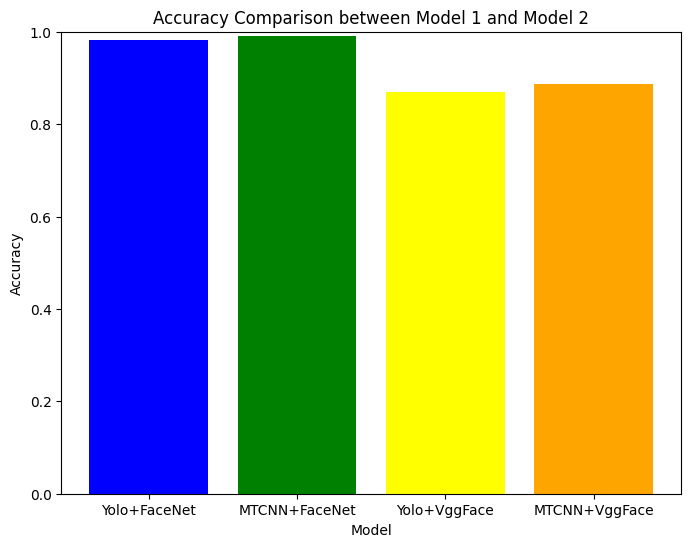

In [51]:
# Gộp kết quả của hai mô hình vào một DataFrame
comparison_df = pd.concat([eval_yolo_facenet, eval_mtcnn_facenet, eval_yolo_vgg, eval_mtcnn_vgg], keys=['Yolo+FaceNet', 'MTCNN+FaceNet', 'Yolo+VggFace', 'MTCNN+VggFace'])

# Vẽ biểu đồ so sánh Accuracy của hai mô hình
accuracy_comparison = comparison_df[comparison_df['Metric'] == 'Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(accuracy_comparison.index.get_level_values(0), accuracy_comparison['Score'], color=['blue', 'green', 'yellow', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Model 1 and Model 2')
plt.ylim(0, 1)
plt.show()

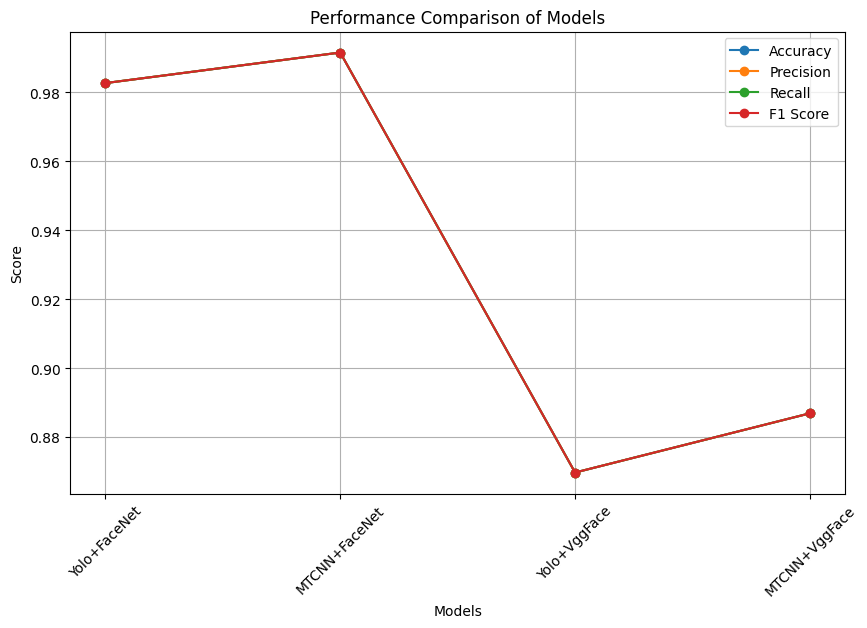

In [63]:
# Tạo biểu đồ đường
plt.figure(figsize=(10, 6))

for metric in result_df.columns[1:]:
    plt.plot(result_df['Model'], result_df[metric], marker='o')

plt.legend(result_df.columns[1:])
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Comparison of Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()